# Preparing a simple FNN 

In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from pathlib import Path
import numpy as np



2025-08-04 16:32:46.869087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 16:32:46.996357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754339567.061555 1137019 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754339567.081904 1137019 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754339567.176782 1137019 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Processing
1. Import data and collate them as numpy array

In [3]:
data_dir = Path('./water_energies_noise')
X = []
Y = []
for file_path in data_dir.glob('*.npz'):
    data_file = np.load(file_path)
    try:
        X.append(data_file['coords'])
        Y.append(data_file['energy'])
    except KeyError:
        raise KeyError('wrong key for npz file!')
    
X = np.stack(X)
Y = np.stack(Y)
print(X.shape)
print(Y.shape)

(1000, 3, 3)
(1000,)


2. split them and prepare them as tf input

In [4]:
x_train, x_valtest, y_train, y_valtest = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.33, random_state=42)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(700, 3, 3) (700,)
(201, 3, 3) (201,)
(99, 3, 3) (99,)


3. Prepare dataset, batching and shuffle

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset =tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

2025-08-04 16:32:55.205551: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Define model

In [6]:
def train(train_dataset, val_dataset, epochs=1000):
    '''
    Simple model:
    1. Input: flatten
    2. Hidden: 1 Dense layer, shape = 64, relu activation
    3. Output: Dense
    '''
    # 
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Flatten(input_shape=(3,3)),
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dense(1)
    # ])
    y_mean = y_train.mean() 
    Initializer = tf.keras.initializers.Constant(y_mean)
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((3, 3, 1), input_shape=(3, 3)),      # Add channel dim
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),       # 32 filters, 2x2 kernel
        # tf.keras.layers.MaxPooling2D(strides=2),
        tf.keras.layers.Flatten(),                                   # Flatten for Dense
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, bias_initializer=Initializer)                                     # Regression output
    ])
    # model = tf.keras.Sequential([
    #     # 1) Keep your reshape
    #     tf.keras.layers.Reshape((3, 3, 1), input_shape=(3, 3)),

    #     # 2) First conv block
    #     tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
    #     tf.keras.layers.BatchNormalization(),           # normalize feature maps
    #     tf.keras.layers.Dropout(0.1),                   # small dropout

    #     # 3) Second conv block
    #     tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'),
    #     tf.keras.layers.BatchNormalization(),
    #     # No pooling—our “image” is tiny, so we just let GlobalAvgPool handle it

    #     # 4) Global pooling instead of flatten
    #     tf.keras.layers.GlobalAveragePooling2D(),        

    #     # 5) Dense head
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dropout(0.2),

    #     # 6) Final regression output
    #     tf.keras.layers.Dense(1)
    # ])
    model.compile(optimizer='adam', loss='mse')

    
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=0)
    return model, history.history

## Training

In [7]:
model, history = train(train_dataset, val_dataset, epochs=1000)

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Plot loss curve

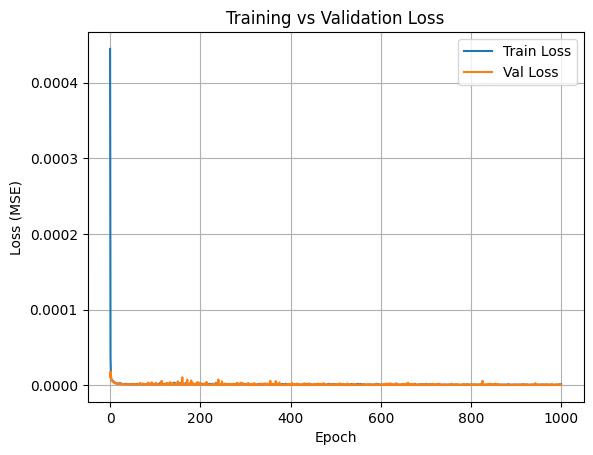

In [8]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [9]:
test_loss = model.evaluate(test_dataset)
print(f"Test MSE loss: {test_loss:.5f}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.9424e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1480e-07
Test MSE loss: 0.00000


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-08-04 16:34:11.057554: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


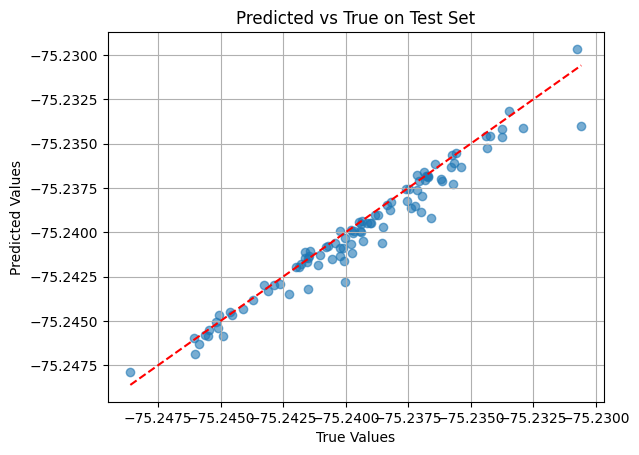

In [10]:
y_pred = model.predict(test_dataset).flatten()
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect prediction line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MSE: 7.155056e-07
MAE: 5.704971e-04
R²:  0.9439


You can see CNN is much much much better than FNN. GNN also fails (or maybe I didnt set up correctly)

## Build a simple GNN
Yep everything is kinda copies from ChatGPT...

1. Re-preprocess X, Y (numpy arrays) into graph data with specktral

In [12]:
import numpy as np
import tensorflow as tf

from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader


def build_adjacency_from_xyz(coords, threshold=2.0):
    """
    Given coords: (n_atoms, 3), returns (n_atoms, n_atoms) adjacency matrix
    with 1s where Euclidean distance < threshold and 0 elsewhere (excluding self-loops)
    """
    n = coords.shape[0]
    dists = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    A = (dists < threshold).astype('float32')
    np.fill_diagonal(A, 0.0)  # remove self-loops
    return A

class XYZGraphDataset(Dataset):
    def __init__(self, X, Y, threshold=2.0, **kwargs):
        self.X = X.astype('float32')         # (N, n_atoms, 3)
        self.Y = Y.astype('float32')         # (N,)
        self.threshold = threshold
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for x, y in zip(self.X, self.Y):
            A = build_adjacency_from_xyz(x, threshold=self.threshold)  # shape (n_atoms, n_atoms)
            graphs.append(Graph(x=x, a=A, y=np.array([y])))
        return graphs

In [13]:
from spektral.layers import GraphSageConv, GlobalSumPool

class GNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        initializer = tf.keras.initializers.HeNormal()
        self.conv1 = GraphSageConv(64, activation='relu')
        self.conv2 = GraphSageConv(64, activation='relu')
        self.pool = GlobalSumPool()
        self.dense = tf.keras.layers.Dense(1, 
                                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05),
                                           bias_initializer=tf.keras.initializers.Zeros())

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.pool([x, i])
        return self.dense(x)



2. Define model

In [14]:
def train_GNN(x_train, y_train,
              x_val, y_val, 
              epochs=10, batch_size=32, threshold=2.0):
    # Create dataset
    train_dataset = XYZGraphDataset(x_train, y_train, threshold=threshold)
    train_loader = DisjointLoader(train_dataset, epochs=epochs, batch_size=batch_size, shuffle=True)

    val_dataset = XYZGraphDataset(x_val, y_val, threshold=threshold)
    val_loader = DisjointLoader(val_dataset, epochs=epochs, batch_size=batch_size, shuffle=False)
    
    # Build and compile model
    with tf.device('/CPU:0'):
        model = GNNModel()
        model.compile(optimizer='adam', loss='mse')

        # Train
        history = model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch, 
                            validation_data=val_loader.load(), validation_steps=val_loader.steps_per_epoch,
                            epochs=epochs)    
    
    return model, history.history


3. Train

In [15]:
model, history = train_GNN(x_train=x_train,y_train=y_train,
                           x_val=x_val,y_val=y_val,
                           epochs=1000)


Epoch 1/1000
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5591.0293

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'XYZGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5546.2246 - val_loss: 5481.3013
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5442.3882 - val_loss: 5402.4253
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5367.9814 - val_loss: 5329.8320
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5294.8677 - val_loss: 5256.0220
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5220.6704 - val_loss: 5181.5459
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5145.8979 - val_loss: 5106.2266
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5069.8867 - val_loss: 5029.5190
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4992.7241 - val_loss: 4952.0137
Epoch 9/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4915.2520 - val_loss: 4874.6538
Epoch 10/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4837.9902 - val_loss: 4797.5684
Epoch 11/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4761.2944 - val_loss: 4721.403

2025-08-04 16:35:39.607783: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0716e-07
Epoch 854/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9395e-07
Epoch 855/1000
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6378e-07 

2025-08-04 16:35:39.857370: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3383e-07
Epoch 856/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5235e-07
Epoch 857/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2807e-07
Epoch 858/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1524e-06
Epoch 859/1000
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1218e-06

2025-08-04 16:35:40.359823: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0832e-06
Epoch 860/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4774e-07
Epoch 861/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6042e-07
Epoch 862/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3585e-07
Epoch 863/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2428e-06
Epoch 864/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5034e-07
Epoch 865/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5792e-07
Epoch 866/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8031e-07
Epoch 867/1000
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1581e-06

2025-08-04 16:35:41.185869: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0170e-06
Epoch 868/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2862e-06
Epoch 869/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3223e-07
Epoch 870/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8536e-07
Epoch 871/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4336e-07
Epoch 872/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4912e-07
Epoch 873/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5579e-07
Epoch 874/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4762e-06
Epoch 875/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1828e-06
Epoch 876/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6431e-07
Epoch 877/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3873e-07
Epoch 878/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0354e-06
Epoch 879/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6452e-07
Epoch 880/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.00

2025-08-04 16:35:42.737423: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4594e-07
Epoch 885/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9703e-07
Epoch 886/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4700e-07
Epoch 887/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5233e-07
Epoch 888/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7394e-07
Epoch 889/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8854e-07
Epoch 890/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2736e-06
Epoch 891/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1683e-06
Epoch 892/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6369e-07
Epoch 893/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2263e-06
Epoch 894/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0785e-06
Epoch 895/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6844e-07
Epoch 896/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7817e-07
Epoch 897/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.95

2025-08-04 16:35:45.093998: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5338e-06
Epoch 917/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5287e-06
Epoch 918/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4795e-06
Epoch 919/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4382e-06
Epoch 920/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144    
Epoch 921/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 922/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6112e-04
Epoch 923/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5348e-05
Epoch 924/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2578e-05
Epoch 925/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7711e-05
Epoch 926/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4671e-05
Epoch 927/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3118e-05
Epoch 928/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0574e-05
Epoch 929/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0353e-

2025-08-04 16:35:50.641998: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3858e-06
Epoch 981/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5154e-06
Epoch 982/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2656e-06
Epoch 983/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0722e-06
Epoch 984/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0854e-06
Epoch 985/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8938e-07
Epoch 986/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5955e-07
Epoch 987/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0826e-06
Epoch 988/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4986e-07
Epoch 989/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1698e-07
Epoch 990/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1642e-06
Epoch 991/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9867e-07
Epoch 992/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9401e-07
Epoch 993/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.04

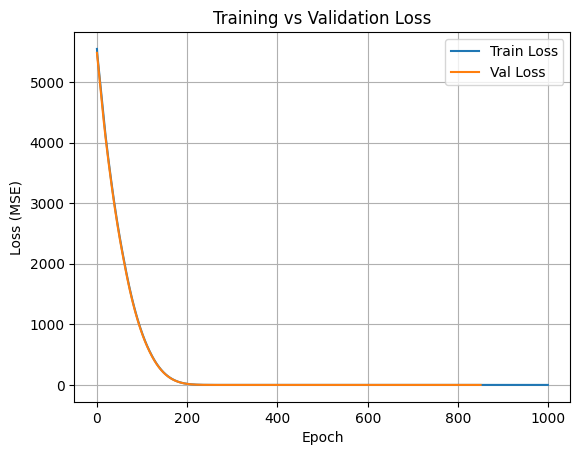

In [16]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
print(x_test.shape, y_test.shape)

(99, 3, 3) (99,)


In [18]:
# Create test dataset and loader
test_dataset = XYZGraphDataset(x_test, y_test, threshold=2.0)
test_loader = DisjointLoader(test_dataset, epochs=1, batch_size=32, shuffle=False)

# Evaluate on test set
test_loss = model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
print(f"Test MSE loss: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9467e-07 
Test MSE loss: 0.00


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
y_pred shape: (99,)


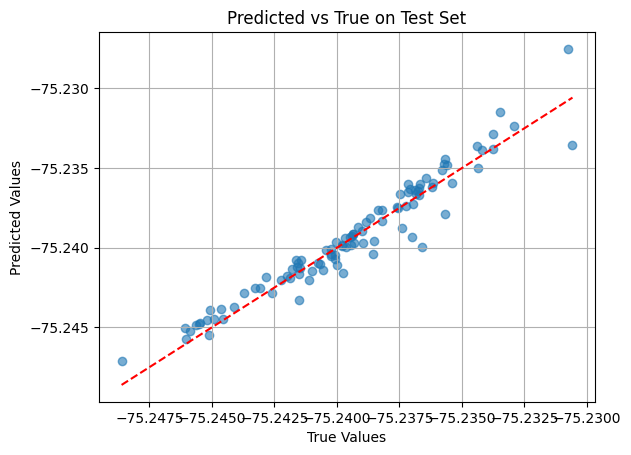

In [19]:
# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()

# 3) Now y_pred.shape == y_true.shape == 99
print("y_pred shape:", y_pred.shape)

# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()



In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MSE: 8.953868e-07
MAE: 6.838548e-04
R²:  0.9298
